In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

Matplotlib is building the font cache; this may take a moment.


#Preprocess the Dataset 

In [ ]:
# Define paths
base_dir = r'C:\Users\nayer\pneumonia-detection\data\chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Data generators with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% of training data for validation
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#Build the CNN Model

In [4]:
# Build CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

#Train the Model

In [9]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# Save the model
model.save(r'C:\Users\nayer\pneumonia-detection\models\cnn_base_model.h5')

Epoch 1/20
131/131 [==============================] - 286s 2s/step - loss: 0.3174 - accuracy: 0.8613 - val_loss: 0.1774 - val_accuracy: 0.9348
Epoch 2/20
131/131 [==============================] - 107s 818ms/step - loss: 0.1093 - accuracy: 0.9617 - val_loss: 0.1462 - val_accuracy: 0.9569
Epoch 3/20
131/131 [==============================] - 172s 1s/step - loss: 0.0780 - accuracy: 0.9708 - val_loss: 0.1144 - val_accuracy: 0.9626
Epoch 4/20
131/131 [==============================] - 94s 713ms/step - loss: 0.0773 - accuracy: 0.9703 - val_loss: 0.1255 - val_accuracy: 0.9569
Epoch 5/20
131/131 [==============================] - 145s 1s/step - loss: 0.0559 - accuracy: 0.9799 - val_loss: 0.1040 - val_accuracy: 0.9607
Epoch 6/20
131/131 [==============================] - 100s 759ms/step - loss: 0.0452 - accuracy: 0.9849 - val_loss: 0.1399 - val_accuracy: 0.9492
Epoch 7/20
131/131 [==============================] - 238s 2s/step - loss: 0.0276 - accuracy: 0.9914 - val_loss: 0.1406 - val_accuracy

#Evaluate the Model

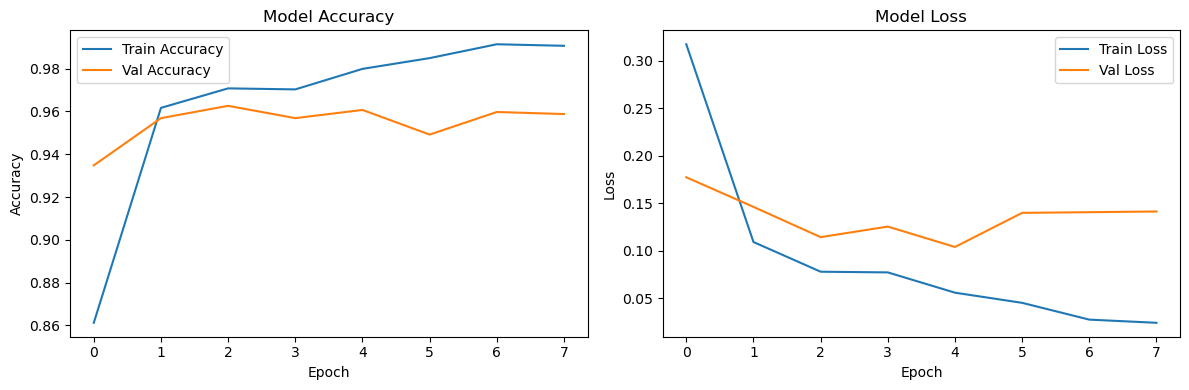

20/20 [==============================] - 14s 738ms/step - loss: 1.4466 - accuracy: 0.7276
Test Accuracy: 0.7276
20/20 [==============================] - 6s 304ms/step
Confusion Matrix:
 [[ 26 208]
 [ 42 348]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.38      0.11      0.17       234
   Pneumonia       0.63      0.89      0.74       390

    accuracy                           0.60       624
   macro avg       0.50      0.50      0.45       624
weighted avg       0.53      0.60      0.52       624



<Figure size 640x480 with 0 Axes>

In [10]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save plot
plt.savefig(r'C:\Users\nayer\pneumonia-detection\docs\base_cnn_plot.png')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# Confusion matrix and classification report
test_generator.reset()
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))